In [1]:
import numpy as np
import matplotlib.pyplot as plt
import wmap_camb_example

import corner


data to fit: We want the combined (not binned) version of the spectrum. This gives the measured variance of the sky as a function of multipole l. WMAP does not measure the monopole, and the dipole is set by the motion of the Earth/Milky Way relative to the CMB reference frame. So, the spectrum starts with the quadrupole (l = 2). The first column is the multipole index, the second is the measured power spectrum, and the third is the error in that. For simplicity, we will treat the errors as Gaussian and uncorrelated, though that is not quite accurate. The final two columns break down the error into the instrument noise part and the “cosmic variance” part, due to the fact that we only have a finite number of modes in the sky to measure.

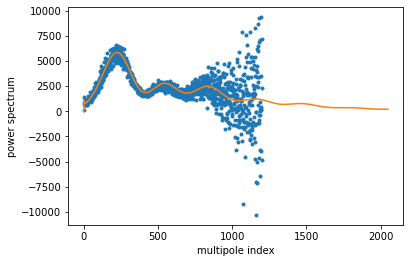

In [2]:
#given code
plt.ion()

#[H_0, w_bh2, w_ch2, tau, A_s, slope]
pars=np.asarray([65,0.02,0.1,0.05,2e-9,0.96])

#[multipole index, measured power spectrum, error, instrument noise part, “cosmic variance” part]
wmap=np.loadtxt('wmap_tt_spectrum_9yr_v5.txt')

plt.clf();
# plt.errorbar(wmap[:,0],wmap[:,1],wmap[:,2],fmt='*', alpha=0.1)
plt.plot(wmap[:,0],wmap[:,1],'.') 

cmb=wmap_camb_example.get_spectrum(pars)

plt.plot(cmb) #what really is the x values here then?
plt.xlabel("multipole index")
plt.ylabel("power spectrum")

plt.show()

### 2) 
Using Gaussian, uncorrelated errors, what do you get for χ2 for the model in my example script, where the Hubble constant H_0 = 65 km/s, the physical baryon density $ω_bh^2=0.02$, the cold dark matter density $ω_ch^2 = 0.1$ the optical depth $τ = 0.05$, the primordial amplitude of fluctuations is $A_s = 2 × 10^{−9}$, and the slope of the primordial power law is 0.96 (where 1 would be scale-invariant). The baryon/dark matter densities are defined relative to the critical density required to close the universe, scaled by h^2 where $h ≡ H_0/100 ∼ 0.7$.   
Note that the universe is assumed to be spatially flat (for reasons too long to justify here), so the dark matter density relative to critical for these parameters would be $1 − (ω_bh^2 + ω_ch^2)/h^2 =71.6%$ for the model assumed here. (You may want to play around plotting different models as you change parameters to get a sense for how the CMB depends on them.)   
If everything has gone well, you should get something around 1588 (please give a few extra digits) for χ2 for this model.

In [3]:
#calculates chi^2
def chisq(data,pars):
    x=data[0]
    y=data[1]
    noise=data[2]
    
    #enforce prior - set chi to inf if tau is negative to not get these terms
    if pars[3] < 0:
        chisq = np.inf
    else:
        model=cmbfun(x,pars)[2:]

        chisq=np.sum( (y-model)**2/noise**2)
    
    return chisq

def cmbfun(x,pars):
    #call the cmb function with the current parameters
    y = wmap_camb_example.get_spectrum(pars, len(x))
    return y

In [4]:
#chi: sum( (data - fitted)^2/sigma^2 )

#assuming Gaussian, uncorrelated errors --> N is diagonal and sigma_i is simplly the error on each value

#[H_0, w_bh2, w_ch2, tau, A_s, slope]
pars=np.asarray([65,0.02,0.1,0.05,2e-9,0.96])
cmb=wmap_camb_example.get_spectrum(pars)

chiSq = 0

for i in range(0, len(wmap)):
    
    chiSq += (wmap[i,1]-cmb[i+2])**2 / wmap[i,2]**2
#     print((wmap[i,1]-cmb[i])**2 / wmap[i,2]**2)

print("Chi squared is: {}".format(chiSq)) #hmm not that close

#my actual chisquared function is slightly different???
print(chisq([wmap[:,0], wmap[:,1], wmap[:,2]], pars))

Chi squared is: 1588.2376532931519
1588.4366720631901


### 3) 
Keeping the optical depth fixed at 0.05, write a Newton’s method/LevenbergMarquardt minimizer and use it to find the best-fit values for the other parameters, and their errors. What are they?   
If you were to keep the same set of parameter but now float τ, what would you expect the new errors to be? Note that CAMB does not provide derivatives with respect to parameters, so you’ll have to come up with something for that. *Please also provide a plot showing why we should believe your derivative estimates.*

In [5]:
#numerical derivative, taking a couple points
def derive(x, params, i, Min, Max, steps):

    fitP = params[i]

    var = np.linspace(fitP - Min , fitP + Max, steps)

    smaller = np.where(var < fitP)[0][-1]
    bigger = np.where(var > fitP)[0][0]
        
    paramArr = [ np.where(params==fitP, v, params) for v in var]

    #quite slow - this is not going to be efficent
    y = np.array([wmap_camb_example.get_spectrum(p, 1820)[2:] for p in paramArr])
    
    slope = [(y[bigger,int(j)] - y[smaller,int(j)]) / (var[bigger] - var[smaller]) for j in x]
    
    chiArr = []
    for run in y:
        chiSq = 0

        for i in range(0, len(wmap)):
            chiSq += (wmap[i,1]-run[i+2])**2 / wmap[i,2]**2
            
        chiArr.append(chiSq)

    return [slope, y, var, chiArr]

# fix the x off set here

#numerical derivative using just two points
def derive_short(x, params, i, stepSize):

    fitP = params[i]

    x1 = fitP + stepSize
    x2 = fitP - stepSize
       
    paramArr1 = np.where(params==fitP, x1, params)
    paramArr2 = np.where(params==fitP, x2, params)

    y1 = wmap_camb_example.get_spectrum(paramArr1, 1820)[2:]
    y2 = wmap_camb_example.get_spectrum(paramArr2, 1820)[2:]
    
    slope = [(y1[int(j)] - y2[int(j)]) / (x1 - x2) for j in x]

    return [slope]


In [7]:
pars_guess=np.asarray([65, 0.02, 0.1, 0.05, 2e-9, 0.96])
# pars_guess=np.asarray([7.46279762e+01, 6.25474176e-03, 1.66248810e-01, 0.05, 1.31297024e-09, 8.13705641e-01])
# pars_guess=np.asarray([7.46279762e+01, 1.15e-02, 1.66248810e-01, 0.05, 1.31297024e-09, 8.13705641e-01])

x=wmap[:,0]

# results = derive(x, pars_guess, 0, 10, 10, 8)
results = derive(x, pars_guess, 3, 0.04, 0.04, 8)

slope = results[0]
y = results[1]
var = results[2]
chi_vals = results[3]

In [109]:
results_short = derive_short(x, pars_guess, 3, 0.04/8)[0]

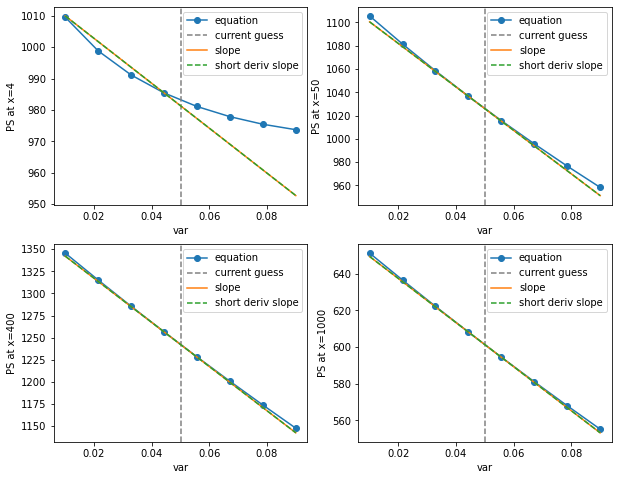

In [111]:
fig, ax = plt.subplots(2, 2, figsize=(10,8))

axs = ax.flatten()
current = pars_guess[3]

for i, x in enumerate([4, 50, 400, 1000]):

    #mx + b
    b = y[3,x] - slope[x]*var[3]
    b_short = y[3,x] - results_short[x]*var[3]

    #dy/dh_0 = y - y_1 / ( h0 - h0_1)

    #dep on x value
    axs[i].plot(var, y[:,x], label='equation', marker="o")
    axs[i].set_xlabel("var")
    axs[i].set_ylabel("PS at x={}".format(x))
    axs[i].axvline(current, color='grey', ls="--", label="current guess")
    axs[i].plot(var, slope[x]*var + b, label='slope')
    axs[i].plot(var, results_short[x]*var + b_short, label='short deriv slope', ls="--")

    axs[i].legend()

plt.show()

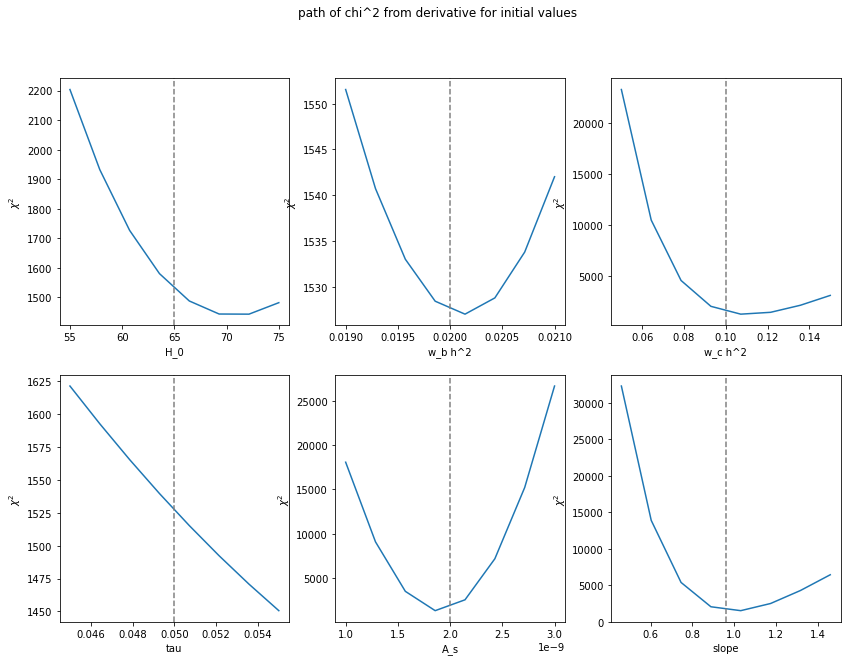

In [8]:
#really want derive of X^2 - so calculate this
#should look like a line -> want data points to move linearily so we have safetly ignore cross terms

# do this for all the values - and again after the run with a new center
variables = ['H_0', 'w_b h^2', 'w_c h^2', 'tau', 'A_s', 'slope']
pars_guess=np.asarray([65, 0.02, 0.1, 0.05, 2e-9, 0.96])

x=wmap[:,0]

fig, ax = plt.subplots(2, 3, figsize=(12,9))
axs = ax.flatten()
    
step = [10, .001, 0.05, 0.005, 1e-9, 0.5]

for i in range(0, 6):
#     print(variables[i])
    # results = derive(x, pars_guess, 0, 10, 10, 8)
    results = derive(x, pars_guess, i, step[i], step[i], 8)

    chi_vals = results[3]

    var = results[2]
    chi_vals = results[3]

    axs[i].plot(var, chi_vals)
    axs[i].axvline(pars_guess[i], color='grey', ls="--", label="current guess")
    axs[i].set_ylabel("$\chi^2$")
    axs[i].set_xlabel(variables[i])

fig.suptitle("path of chi^2 from derivative for initial values")
plt.show()

In [17]:
#function and derivatives
def f_cmb(x,params):
    H0=params[0]
    ombh2=params[1]
    omch2=params[2]
#     tau=pars[3]
    As=params[3]
    ns=params[4]
    
    pars = np.insert(params, 2, 0.05)
    
    y = wmap_camb_example.get_spectrum(pars, lmax=len(x))[:-2]
    
    derivs=np.zeros([len(x),len(params)])
    
    derivs[:,0]=derive_short(x, pars, 0, 4)[0]
    derivs[:,1]=derive_short(x, pars, 1, 0.001/2.0)[0]
    derivs[:,2]=derive_short(x, pars, 2, 0.05/2.0)[0]
    derivs[:,3]=derive_short(x, pars, 4, 1e-9/2.0)[0]
    derivs[:,4]=derive_short(x, pars, 5, 0.5/2.0)[0]
    
    return y,derivs

In [18]:
# newton's method with Levenberg-Marquardt

x=wmap[:,0]

sig=wmap[:,2]
y=wmap[:,1]
N=np.eye(len(x))*sig**2
Ninv=np.eye(len(x))/sig**2

tau = 0.05 #set
#[H_0, w_bh2, w_ch2, _, A_s, slope]
pars_guess=np.asarray([65, 0.02, 0.1, 2e-9, 0.96])

pars_cur=pars_guess.copy()

pars_savedArr = []
Lambda = 0
prev_chi = np.inf

for iter in range(9):
    y_pred,derivs=f_cmb(x,pars_cur)
    resid=y-y_pred #data minus current model
#     print(resid)
    
    rhs=derivs.T@(Ninv@resid)
    lhs=derivs.T@Ninv@derivs  

    #rescale this on diagonal
    for i in range(len(lhs[0])):
        lhs[i][i] = (1+Lambda)*lhs[i][i]
    
    step=np.linalg.inv(lhs)@rhs
    
    chi_pars = np.insert(pars_cur+step, 2, 0.05)
    chi = chisq([x, y, sig], chi_pars)
    
    #chiSq improves, take step
    if chi < prev_chi:
        pars_cur = pars_cur+step
        pars_savedArr.append(pars_cur) #save values for corvarience matrix
        Lambda = Lambda / np.sqrt(2) #make lambda setp smaller
        print('iteration ',iter,' has step ',step)

    #chiSq doesn't improves
    else:
        if Lambda == 0:
            Lambda = 2
        else:
            Lambda = 2*Lambda
#             pars_cur = pars_cur+step
        print('iteration ',iter, 'has step ',step, 'and increase lambda to ',Lambda)
    
    prev_chi = chi #save new chisquared for next step

    print("chisq: ", chi)
    

par_errs=np.sqrt(np.diag(np.linalg.inv(lhs)))
print('final parameters are ', pars_cur,' with errors ', par_errs)

parsFirstNM = pars_cur

iteration  0  has step  [ 3.56898189e+01 -4.84323847e-03 -2.07662342e-02 -7.42398037e-10
 -9.23726936e-03]
chisq:  3860.4446769717806
iteration  1  has step  [-3.67977850e+00  9.38978722e-03  8.40111790e-03  4.24915353e-10
  7.21641240e-02]
chisq:  1813.6423437888432
iteration  2 has step  [-1.80192123e+01 -4.45970142e-03  2.57512657e-02  1.95248591e-10
 -5.83902679e-02] and increase lambda to  2
chisq:  5205.3037264697205
iteration  3  has step  [ 3.26406790e+00 -1.25371014e-03  1.42571739e-03 -1.02530281e-11
  6.25319400e-03]
chisq:  1531.8672303948865
iteration  4  has step  [ 2.70254845e+00 -7.53498174e-04  1.09501968e-03 -4.23040417e-12
  1.83143884e-03]
chisq:  1444.178188586538
iteration  5  has step  [ 1.96975908e+00 -3.30703144e-04  8.56774796e-04 -6.08296363e-13
 -4.71244371e-04]
chisq:  1425.809221398766
iteration  6  has step  [ 1.25148956e+00 -6.29552825e-05  7.42663065e-04  1.52580395e-12
 -8.60257522e-04]
chisq:  1425.6824819300045
iteration  7 has step  [ 6.75754741e-01

In [19]:
delt = lhs

# print(pars_savedArr)
# print(delt)

for i in range(delt.shape[1]):
#     print(delt[:,i], delt[:,i].mean())
    delt[:,i]=delt[:,i]-delt[:,i].mean()
    
mycov=delt.T@delt/delt.shape[0]
mycov

array([[ 4.86339448e+20, -7.58589567e+21,  3.29074524e+24,
        -4.75359721e+32,  2.66127501e+23],
       [-7.58589567e+21,  1.18324379e+23, -5.13288612e+25,
         7.41463449e+33, -4.15104196e+24],
       [ 3.29074524e+24, -5.13288612e+25,  2.22663497e+28,
        -3.21645250e+36,  1.80071308e+27],
       [-4.75359721e+32,  7.41463449e+33, -3.21645250e+36,
         4.64627875e+44, -2.60119336e+35],
       [ 2.66127501e+23, -4.15104196e+24,  1.80071308e+27,
        -2.60119336e+35,  1.45626366e+26]])

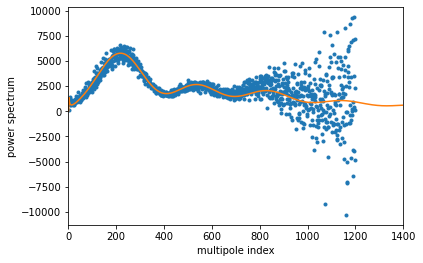

In [14]:
#plot to see how the 5 fitted parameters look
#[H_0, w_bh2, w_ch2, tau, A_s, slope]
pars_fitted=np.insert(pars_cur, 2, 0.05)

#[multipole index, measured power spectrum, error, instrument noise part, “cosmic variance” part]

plt.plot(wmap[:,0],wmap[:,1],'.') 

cmb=wmap_camb_example.get_spectrum(pars_fitted)

plt.plot(cmb) #what really is the x values here then?
plt.xlabel("multipole index")
plt.ylabel("power spectrum")
plt.xlim(0, 1400)

plt.show()

*If you were to keep the same set of parameter but now float τ, what would you expect the new errors to be?*

I expect the error to be much worse from just changing tau, we can't really compare errors, but just looking at $\chi ^2$, we can see below that this gets much worst values when only fitting tau, propably because there is no good way to apply the prior we know where tau must be non-negative.

In [15]:
#function and derivatives just changing tau
def f_cmb_tau(x,tau):

    pars = np.insert(pars_cur, 3, tau)
    print(pars)
    
    y = wmap_camb_example.get_spectrum(pars, lmax=len(x))[:-2]
    
    derivs=np.zeros([len(x),1])
    
    if tau < 0.0:
        derivs[:,0] = 10000*np.ones(len(x))
        print("n")
    else:
        derivs[:,0]=derive_short(x, pars, 3, 0.005)[0]
    
    return y,derivs

In [16]:
x=wmap[:,0]

sig=wmap[:,2]
y=wmap[:,1]
N=np.eye(len(x))*sig**2
Ninv=np.eye(len(x))/sig**2

tau_cur = 0.05 #set

#using the L-M method, just add prior into chi squared
tau_savedArr = []
Lambda = 0
prev_chi = np.inf

for iter in range(18):
    
    if tau_cur < 0:
        print("problem, negative tau")
#         tau_cur = np.abs(tau_cur) #how can i actually fix this?

    y_pred,derivs=f_cmb_tau(x,tau_cur)
    resid=y-y_pred #data minus current model
    
#     print(derivs)
    
    rhs=derivs.T@(Ninv@resid)
    lhs=derivs.T@Ninv@derivs
#     print(rhs, lhs)

    for i in range(len(lhs[0])):
#         print(derivs[i][i])
        lhs[i][i] = (1+Lambda)*lhs[i][i]
    
    step=np.linalg.inv(lhs)@rhs
    
#     chi_pars = np.insert(pars_cur+step, 2, 0.05)
    chi_pars = np.insert(pars_cur, 3, tau_cur+step)
    chi = chisq([x, y, sig], chi_pars)
    
    #chiSq improves, take step
    if chi < prev_chi:
        tau_cur=tau_cur+step
        tau_savedArr.append(tau_cur) #save values for corvarience matrix
        prev_chi = chi #save new chqsquared for next step
        
        Lambda = Lambda / np.sqrt(2) #make lambda setp smaller
        print('iteration ',iter,' has step ',step)

    #chiSq doesn't improves, take step according to lambda    
    else:
        if Lambda == 0:
            Lambda = 2
        else:
            Lambda = 2*Lambda
        print('iteration ',iter,' increase lambda to ',Lambda, ' tried step ',step)
    
    print("chisq: ", chi)    
    
par_errs=np.sqrt(np.diag(np.linalg.inv(lhs)))
print('final parameters are ', tau_cur,' with errors ',par_errs)

[1.06818374e+02 2.21536707e-02 9.22440572e-02 5.00000000e-02
 1.66965633e-09 1.02968166e+00]
iteration  0  increase lambda to  2  tried step  [-0.08221582]
chisq:  inf
[1.06818374e+02 2.21536707e-02 9.22440572e-02 5.00000000e-02
 1.66965633e-09 1.02968166e+00]
iteration  1  has step  [-0.02740527]
chisq:  3182.2848896622013
[1.06818374e+02 2.21536707e-02 9.22440572e-02 2.25947282e-02
 1.66965633e-09 1.02968166e+00]
iteration  2  has step  [-0.02118226]
chisq:  2759.64038801927
[1.06818374e+02 2.21536707e-02 9.22440572e-02 1.41246756e-03
 1.66965633e-09 1.02968166e+00]
iteration  3  increase lambda to  1.9999999999999998  tried step  [-0.02234651]
chisq:  inf
[1.06818374e+02 2.21536707e-02 9.22440572e-02 1.41246756e-03
 1.66965633e-09 1.02968166e+00]
iteration  4  increase lambda to  3.9999999999999996  tried step  [-0.01489767]
chisq:  inf
[1.06818374e+02 2.21536707e-02 9.22440572e-02 1.41246756e-03
 1.66965633e-09 1.02968166e+00]
iteration  5  increase lambda to  7.999999999999999  tr

In [91]:
def f_cmb_all(x,params):
    H0=params[0]
    ombh2=params[1]
    omch2=params[2]
    tau=pars[3]
    As=params[4]
    ns=params[5]
    
#     pars = params
    
    y = wmap_camb_example.get_spectrum(params, lmax=len(x))[:-2]
    
    derivs=np.zeros([len(x),len(params)])
    
    derivs[:,0]=derive_short(x, params, 0, 4)[0]
    derivs[:,1]=derive_short(x, params, 1, 0.001/2.0)[0]
    derivs[:,2]=derive_short(x, params, 2, 0.05/2.0)[0]
    
    if tau < 0.0:
        derivs[:,0] = 10000*np.ones(len(x))
        print("n")
    else:
        derivs[:,3]=derive_short(x, params, 3, 0.005)[0]
    
    derivs[:,4]=derive_short(x, params, 4, 1e-9/2.0)[0]
    derivs[:,5]=derive_short(x, params, 5, 0.5/2.0)[0]
    
    return y,derivs

In [100]:
#fit all the varibles now

# parsFirstNM

x=wmap[:,0]

sig=wmap[:,2]
y=wmap[:,1]
N=np.eye(len(x))*sig**2
Ninv=np.eye(len(x))/sig**2

tau = 0.05 #set
#[H_0, w_bh2, w_ch2, _, A_s, slope]

#use results from first run
# pars_guess=np.insert(parsFirstNM, 3, 0.05)
# print(pars_guess)

pars_cur=pars_fitted

pars_savedArr_all = []
Lambda = 0
prev_chi = np.inf

for iter in range(20):
    y_pred,derivs=f_cmb_all(x,pars_cur)
    resid=y-y_pred #data minus current model
    
    rhs=derivs.T@(Ninv@resid)
    lhs=derivs.T@Ninv@derivs

    #rescale diga with lambda
    for i in range(len(lhs[0])):
        lhs[i][i] = (1+Lambda)*lhs[i][i]
    
    step=np.linalg.inv(lhs)@rhs
    
#     chi_pars = np.insert(pars_cur+step, 2, 0.05)
    chi = chisq([x, y, sig], pars_cur+step)
    
    #chiSq improves
    if chi < prev_chi:
        pars_cur = pars_cur+step
        pars_savedArr_all.append(pars_cur) #save values for corvarience matrix
        Lambda = Lambda / np.sqrt(2) #make lambda setp smaller
        print('iteration ',iter,' has step ',step)

    #chiSq doesn't improves
    else:
        if Lambda == 0:
            Lambda = 2
        else:
            Lambda = 2*Lambda
#             pars_cur = pars_cur+step
        print('iteration ',iter, 'has step ',step, 'and increase lambda to ',Lambda)
    
    prev_chi = chi #save new chisquared for next step

    print("chisq: ", chi)
    
#get errors
par_errs=np.sqrt(np.diag(np.linalg.inv(lhs)))
print('final parameters are ',pars_cur,' with errors ',par_errs)

iteration  0  has step  [-1.33897076e+01  2.21630361e-03  1.74599228e-02  3.63721726e-01
  1.42842331e-09  2.10519726e-02]
chisq:  3892.3097512810286
iteration  1  has step  [-1.84514978e+01  5.31258814e-04  3.38737418e-02 -1.87329981e-01
  1.71002053e-10 -7.39781316e-04]
chisq:  1549.0256840647703
iteration  2 has step  [-1.48635461e+01 -5.07474835e-03  2.92879032e-02 -3.07477319e-01
 -1.99927881e-09 -1.69908123e-01] and increase lambda to  2
chisq:  inf
iteration  3  has step  [ 1.82430869e+00 -2.04567615e-04  2.31753231e-03  5.72442095e-03
 -3.51290170e-11  4.60973865e-03]
chisq:  1271.6148614480794
iteration  4  has step  [ 1.15736611e+00 -9.70930063e-07  1.14973470e-03  2.74811351e-03
 -1.61721797e-11 -1.56459344e-03]
chisq:  1236.1956512913234
iteration  5  has step  [ 6.82084233e-01  6.02837952e-05  4.35463037e-04  1.19556785e-03
 -6.71668265e-12 -3.67583418e-03]
chisq:  1236.183581645791
iteration  6 has step  [ 3.76896029e-01  4.19740052e-05  8.07550545e-05  5.99785944e-04
 -3

In [106]:
#get guess at covarience matrix from this, what about diagonal, do we still use sigma^2 or these values here??

# actually use lhs here says Seivers

#is is what i should be using? I'm skipping the first set of params cause those where my initial guess
delt = lhs

# print(pars_savedArr)
# print(delt)

for i in range(delt.shape[1]):
#     print(delt[:,i], delt[:,i].mean())
    delt[:,i]=delt[:,i]-delt[:,i].mean()
    
mycov=delt.T@delt/delt.shape[0]
mycov

array([[ 4.86339448e+20, -7.58589567e+21,  3.29074524e+24,
        -4.75359721e+32,  2.66127501e+23],
       [-7.58589567e+21,  1.18324379e+23, -5.13288612e+25,
         7.41463449e+33, -4.15104196e+24],
       [ 3.29074524e+24, -5.13288612e+25,  2.22663497e+28,
        -3.21645250e+36,  1.80071308e+27],
       [-4.75359721e+32,  7.41463449e+33, -3.21645250e+36,
         4.64627875e+44, -2.60119336e+35],
       [ 2.66127501e+23, -4.15104196e+24,  1.80071308e+27,
        -2.60119336e+35,  1.45626366e+26]])

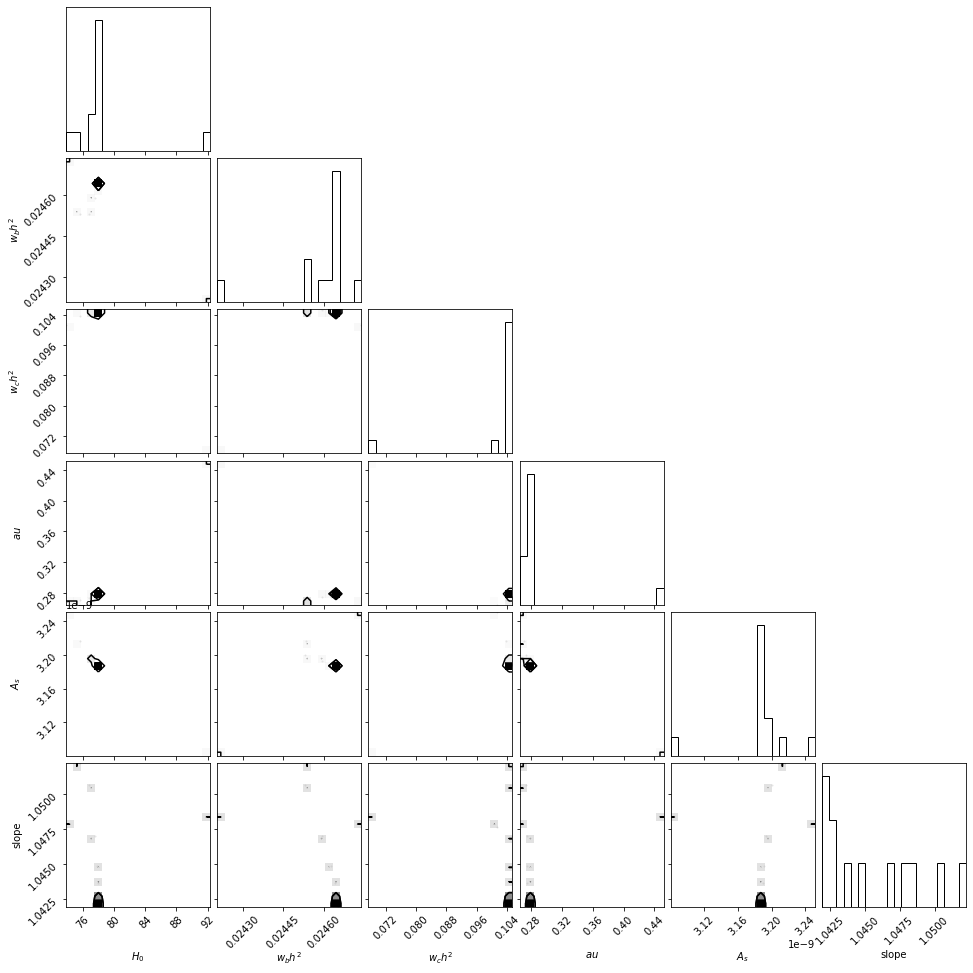

In [103]:
variables = ['$H_0$', '$w_bh^2$', '$w_ch^2$', '$\tau$', '$A_s$', 'slope']

# print(pars_savedArr_all)
figure = corner.corner(pars_savedArr_all, labels=variables)

# figure = corner.corner(pars_savedArr_all, labels=variables, quantiles=[0.16, 0.5, 0.84], show_titles=True, title_kwargs={"fontsize": 12})

### 4) 
Now write a Markov-chain Monte Carlo where you fit the basic 6 parameters, including τ. However, note that we know the optical depth can’t be negative, so you should reject any steps that try to sample a negative τ.   

As a reminder, you can draw samples of correlated data from a covariance matrix with   
r = np.linalg.cholesky(mat);   
d = np.dot(r, np.random.randn(r.shape[0])).    
You will want to use the covariance matrix from part 2) (3?) when drawing samples for the MCMC.   

What are your parameter limits now? Please also present an argument as to why you think your chains are converged.   

[ 7.93143952e+01 -2.86943803e-03  1.53661549e-01  4.05062814e-10
  6.89924867e-01]


### 5) 
The Planck satellite has independently measured the CMB sky, and finds
that the optical depth is 0.0544 ± 0.0073. Run a chain where you add this in as a prior on the value of τ. What are your new parameter values/constraints?    
You can also take your chain from part 4) and importance sample it (weighting by the prior) with the Planck τ prior. How to those results compare to the full chain results?   
(p316 in tb)